In [1]:
import torch
import torchvision
import numpy as np
from torch import nn
from torch.nn import functional as F
from sklearn.preprocessing import StandardScaler
from LeukemiaNet import *

import matplotlib.pyplot as plt

torch.manual_seed(0)

c:\Users\micha\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\micha\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Using cache found in C:\Users\micha/.cache\torch\hub\pytorch_vision_v0.10.0


In [2]:
aug1 = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(p=0.5)
    ])
aug2 = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomVerticalFlip(p=0.5)
    ])
aug3 = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomRotation(180)
    ])
aug4 = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.GaussianBlur(3, sigma=(0.1, 2.0))
    ])

images = torchvision.datasets.ImageFolder('./Training_and_Validation_Set/', transform=torchvision.transforms.ToTensor())
images_aug1 = torchvision.datasets.ImageFolder('./Training_and_Validation_Set/', transform=aug1)
images_aug2 = torchvision.datasets.ImageFolder('./Training_and_Validation_Set/', transform=aug2)
images_aug3 = torchvision.datasets.ImageFolder('./Training_and_Validation_Set/', transform=aug3)
images_aug4 = torchvision.datasets.ImageFolder('./Training_and_Validation_Set/', transform=aug4)

dataset = torch.utils.data.ConcatDataset([images, images_aug1, images_aug2, images_aug3, images_aug4])

In [3]:
class_count = {}
for _, label in dataset:
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1

num_train = 300*4*5
num_val = 100*4*5

train_sampler = torch.utils.data.WeightedRandomSampler([0.25,0.25,0.25,0.25], num_train)
val_sampler = torch.utils.data.WeightedRandomSampler([0.25,0.25,0.25,0.25], num_val)

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [num_train, num_val])

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [4]:
free_cuda(feature_extractor)
classifier = LeukemiaClassifier()
# Load the pretrained weights from previous training
classifier.load_state_dict(torch.load('classifier.pth'))

<All keys matched successfully>

In [7]:
loss, tr_acc, vl_acc = fine_tune(classifier, train_loader, val_loader, epochs=1, initial_lr=3e-4)

Fine-tuning for 1 epochs using cuda...
Epoch 1 |	 Loss: 0.79 |	 Training Accuracy: 0.60 |	 Validation Accuracy: 0.59
Epoch 1 |	 Loss: 1.13 |	 Training Accuracy: 0.63 |	 Validation Accuracy: 0.64
Epoch 1 |	 Loss: 1.16 |	 Training Accuracy: 0.69 |	 Validation Accuracy: 0.70
Epoch 1 |	 Loss: 1.24 |	 Training Accuracy: 0.75 |	 Validation Accuracy: 0.75
Epoch 1 |	 Loss: 1.05 |	 Training Accuracy: 0.78 |	 Validation Accuracy: 0.78
Epoch 1 |	 Loss: 1.07 |	 Training Accuracy: 0.79 |	 Validation Accuracy: 0.80
Epoch 1 |	 Loss: 1.04 |	 Training Accuracy: 0.80 |	 Validation Accuracy: 0.81
Epoch 1 |	 Loss: 1.07 |	 Training Accuracy: 0.80 |	 Validation Accuracy: 0.80
Epoch 1 |	 Loss: 1.10 |	 Training Accuracy: 0.82 |	 Validation Accuracy: 0.82
Epoch 1 |	 Loss: 1.01 |	 Training Accuracy: 0.84 |	 Validation Accuracy: 0.83
Epoch 1 |	 Loss: 1.01 |	 Training Accuracy: 0.86 |	 Validation Accuracy: 0.85
Epoch 1 |	 Loss: 1.02 |	 Training Accuracy: 0.87 |	 Validation Accuracy: 0.87
Epoch 1 |	 Loss: 1.01 |	 

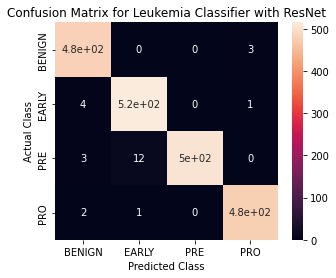

              precision    recall  f1-score   support

      BENIGN       0.98      0.99      0.99       482
       EARLY       0.98      0.99      0.98       520
         PRE       1.00      0.97      0.99       519
         PRO       0.99      0.99      0.99       479

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



In [13]:
model = classifier.cpu()
feature_extractor = LeukemiaNet_Features_Resnet()
feature_extractor.load_state_dict(torch.load('FeatureExtractor_tuned.pt'))
feature_extractor = feature_extractor.cpu()
model.eval()
feature_extractor.eval()
predicted_labels = np.array([])
actual_labels = np.array([])
for x, y in val_loader:
    predicted_labels = np.append(predicted_labels, model(feature_extractor(x)).argmax(dim=1).numpy())
    actual_labels = np.append(actual_labels, y.numpy())
class_names = ['BENIGN','EARLY', 'PRE', 'PRO']
draw_confusion_matrix(predicted_labels, actual_labels)
print_model_report(predicted_labels, actual_labels, class_names)

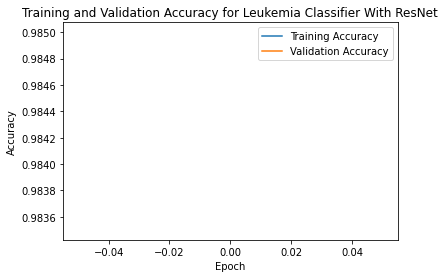

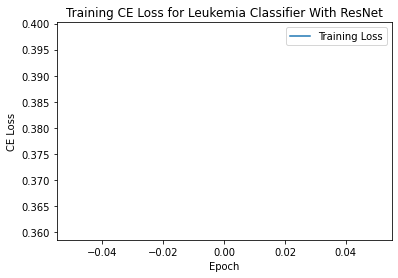

In [14]:
plt.figure(1)
plt.plot(tr_acc, label='Training Accuracy')
plt.plot(vl_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Leukemia Classifier With ResNet')
plt.legend()

plt.figure(2)
plt.plot(loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('CE Loss')
plt.title('Training CE Loss for Leukemia Classifier With ResNet')
plt.legend()